<a href="https://colab.research.google.com/github/isarandi/nlf/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torch torchvision matplotlib opencv-python

In [2]:
# PyTorch version

import os
import torch
import torchvision  # Must import this for the model to load without error

!mkdir -p models
!wget -q -O models/nlf_l_multi.torchscript https://bit.ly/nlf_l_pt


zsh:1: command not found: wget


In [3]:
import os
print(os.getcwd())
print(os.path.exists('models/nlf_l_multi.torchscript'))

/Users/lemon/Documents/TUD/Thesis/Code/nlf
True


### Use NLF model to detect SMPL parameters from a single image

In [4]:
# device = ("cuda" if torch.cuda.is_available()
#           else "mps" if torch.backends.mps.is_available()
#           else "cpu")
device = "cpu"
print(f"Using device: {device}")

model = torch.jit.load("models/nlf_l_multi.torchscript", map_location=device).eval()

# image_path = "/Users/lemon/Documents/TUD/Thesis/Code/avatar-benchmark/data/people_snapshot_public/female-4-casual/frames_without_mask/frame_0012.png"
image_path = "data/dance.jpg"
image = torchvision.io.read_image(image_path).to(device)
frame_batch = image.unsqueeze(0) # [BatchSize, 3, H, W]
print(frame_batch.shape)

Using device: cpu
torch.Size([1, 3, 427, 640])


In [ ]:
with torch.inference_mode():
   pred = model.detect_smpl_batched(frame_batch, model_name='smplx')


In [32]:
pred.keys()

dict_keys(['boxes', 'pose', 'betas', 'trans', 'vertices3d', 'joints3d', 'vertices2d', 'joints2d', 'vertices3d_nonparam', 'joints3d_nonparam', 'vertices2d_nonparam', 'joints2d_nonparam', 'vertex_uncertainties', 'joint_uncertainties'])

In [33]:
# SMPL Parametric predictions
for key in pred.keys():
    print(f"{key} -> {pred[key][0].shape}")

# # Nonparametric joints and vertices
# pred['joints3d_nonparam'], pred['vertices3d_nonparam']
# pred['joints2d_nonparam'], pred['vertices2d_nonparam']
# pred['joint_uncertainties'], pred['vertex_uncertainties']

boxes -> torch.Size([1, 5])
pose -> torch.Size([1, 165])
betas -> torch.Size([1, 10])
trans -> torch.Size([1, 3])
vertices3d -> torch.Size([1, 10475, 3])
joints3d -> torch.Size([1, 55, 3])
vertices2d -> torch.Size([1, 10475, 2])
joints2d -> torch.Size([1, 55, 2])
vertices3d_nonparam -> torch.Size([1, 1024, 3])
joints3d_nonparam -> torch.Size([1, 55, 3])
vertices2d_nonparam -> torch.Size([1, 1024, 2])
joints2d_nonparam -> torch.Size([1, 55, 2])
vertex_uncertainties -> torch.Size([1, 1024])
joint_uncertainties -> torch.Size([1, 55])


### Reconstructs mesh 

In [23]:
# !pip install smplx

In [24]:
import smplx

In [25]:
import os
bm_root = os.getenv('DATA_ROOT', default='.')
bm = smplx.SMPLX(os.path.join(bm_root, 'smplx', 'SMPLX_NEUTRAL.npz'), use_pca=False).eval()

pose = pred['pose'][0]
betas = pred['betas'][0]
transl = pred['trans'][0]
print(f"Pose shape: {pose.shape}, Betas shape: {betas.shape}, Transl shape: {transl.shape}")

res = bm(global_orient=pose[:, :3],
   body_pose=pose[:, 3:22*3],
   betas=betas,
   transl=transl,
   left_hand_pose=pose[:, 25*3:40*3],
   right_hand_pose=pose[:, 40*3:55*3],
   jaw_pose=pose[:, 22*3:23*3],
   leye_pose=pose[:, 23*3:24*3],
   reye_pose=pose[:, 24*3:25*3]
)

print(res.vertices.shape)  # [BatchSize, NumVertices, 3]
print(res.joints.shape)    # [BatchSize, NumJoints, 3]

Pose shape: torch.Size([1, 165]), Betas shape: torch.Size([1, 10]), Transl shape: torch.Size([1, 3])
torch.Size([1, 10475, 3])
torch.Size([1, 127, 3])


### Visulization

In [26]:
# !pip install "git+https://github.com/isarandi/cameralib.git#egg=cameralib"

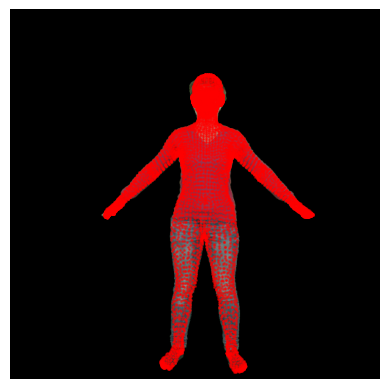

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from nlf.pt import ptu3d

K = ptu3d.intrinsic_matrix_from_field_of_view(55, image.shape[1:3])  # [1,3,3]

def project_vertices(coords3d, K):
    # coords3d: [B,N,3] or [N,3]; K: [B,3,3] or [3,3]
    if coords3d.ndim == 2:  # add batch
        coords3d = coords3d.unsqueeze(0)
    if K.ndim == 2:
        K = K.unsqueeze(0)
    z = coords3d[..., 2:].clamp_min(1e-3)              # avoid division warning/NaN
    projected = coords3d / z
    return torch.einsum('bnk,bjk->bnj', projected, K[..., :2, :])

verts3d = pred['vertices3d'][0].detach().cpu()         # [N,3] or [1,N,3]
verts2d = project_vertices(verts3d, K).squeeze(0).numpy()

fig, ax = plt.subplots()
ax.imshow(image.cpu().numpy().transpose(1, 2, 0))
ax.scatter(verts2d[:, 0], verts2d[:, 1], s=1, c='r', alpha=0.5)
ax.set_axis_off()
plt.show()


In [ ]:
image.shape

torch.Size([3, 427, 640])

### Investigate the model

In [6]:
for key in model.state_dict().keys():
    print(f"{key} -> {model.state_dict()[key].shape}")

crop_model.canonical_lefts -> torch.Size([360, 3])
crop_model.canonical_centers -> torch.Size([147, 2])
crop_model.backbone.1.0.0.weight -> torch.Size([32, 3, 3, 3])
crop_model.backbone.1.0.1.weight -> torch.Size([32])
crop_model.backbone.1.0.1.bias -> torch.Size([32])
crop_model.backbone.1.0.1.running_mean -> torch.Size([32])
crop_model.backbone.1.0.1.running_var -> torch.Size([32])
crop_model.backbone.1.0.1.num_batches_tracked -> torch.Size([])
crop_model.backbone.1.1.0.block.0.0.weight -> torch.Size([32, 32, 3, 3])
crop_model.backbone.1.1.0.block.0.1.weight -> torch.Size([32])
crop_model.backbone.1.1.0.block.0.1.bias -> torch.Size([32])
crop_model.backbone.1.1.0.block.0.1.running_mean -> torch.Size([32])
crop_model.backbone.1.1.0.block.0.1.running_var -> torch.Size([32])
crop_model.backbone.1.1.0.block.0.1.num_batches_tracked -> torch.Size([])
crop_model.backbone.1.1.1.block.0.0.weight -> torch.Size([32, 32, 3, 3])
crop_model.backbone.1.1.1.block.0.1.weight -> torch.Size([32])
crop_